# Tensorflow Neural Network Lab

In [1]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

## DataDownloader

In [2]:
class DataDownloader:
    
    def download(self, url, file):
        """
        Download file from <url>
        :param url: URL to file
        :param file: Local file path
        """
        
        if not os.path.isfile(file):
            print('Downloading '+file+'...')
            urlretrieve(url, file)
            print('Download finished')

In [3]:
dataDownloader = DataDownloader()

# Download the training and test dataset.
dataDownloader.download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
dataDownloader.download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

Download finished
Download finished
All files downloaded.


## DataExtractor

In [4]:
class DataExtractor:
    
    def uncompress_features_labels(self, file):
        """
        Uncompress features and labels from a zip file
        :param file: The zip file to extract the data from
        """
        
        features = []
        labels = []
        
        with ZipFile(file) as zipf:
            # Progress bar
            filenames_pbar = tqdm(zipf.namelist(), unit='files')
            
            # Get features and labels from all files
            for filename in filenames_pbar:
                # Check if the file is a directory
                if not filename.endswith('/'):
                    with zipf.open(filename) as image_file:
                        image = Image.open(image_file)
                        image.load()
                        
                        # Load image data as 1-dimensional array
                        # Use float32 to save on memory space
                        feature = np.array(image, dtype=np.float32).flatten()
                        
                    # Get the letter from the filename
                    label = os.path.split(filename)[1][0]
                    
                    # Append current feature and label
                    features.append(feature)
                    labels.append(label)
                    
        return np.array(features), np.array(labels)

In [5]:
dataExtractor = DataExtractor()

# Get the features and labels from the zip files
train_features, train_labels = dataExtractor.uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = dataExtractor.uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering
is_features_normal = False
is_labels_encoded = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:02<00:00, 4838.91files/s]


All features and labels uncompressed.


## ImageDataNormalizer

In [6]:
class ImageDataNormalizer:
    
    def normalize_grayscale(self, image_data):
        """
        Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
        :param image_data: The image data to be normalized
        :return: Normalized image data
        """
        
        a = 0.1
        b = 0.9
        x_min = 0
        x_max = 255
        
        return a + (((image_data-x_min)*(b-a))/(x_max-x_min))

In [7]:
imageDataNormalizer = ImageDataNormalizer()

# Test Cases
np.testing.assert_array_almost_equal(
    imageDataNormalizer.normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    imageDataNormalizer.normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = imageDataNormalizer.normalize_grayscale(train_features)
    test_features = imageDataNormalizer.normalize_grayscale(test_features)
    is_features_normal = True

print('Image data normalization tests Passed!')

Image data normalization tests Passed!


## OneHotEncoder

In [8]:
class OneHotEncoder:
    
    def one_hot_encode(self, labels):
        lb = LabelBinarizer()
        lb.fit(labels)
        return lb.transform(labels)

In [10]:
oneHotEncoder = OneHotEncoder()

if not is_labels_encoded:
    # Turn labels into numbers and apply One-Hot Encoding
    train_labels = oneHotEncoder.one_hot_encode(train_labels)
    test_labels = oneHotEncoder.one_hot_encode(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encoded = True

print('Labels one-hot-encoded')

Labels one-hot-encoded


In [11]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encoded, 'You skipped the step to one-hot-encode the labels'

In [12]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


## DataSaver

In [13]:
class DataSaver:
    
    def save_data(self, pickle_file):
        if not os.path.isfile(pickle_file):
            print('Saving data to pickle file...')     
            
            try:
                with open(pickle_file, 'wb') as pfile:
                    pickle.dump(
                    {
                        'train_dataset': train_features,
                        'train_labels': train_labels,
                        'valid_dataset': valid_features,
                        'valid_labels': valid_labels,
                        'test_dataset': test_features,
                        'test_labels': test_labels,
                    },
                    pfile,
                    pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', pickle_file, ':', e)
                raise

In [14]:
dataSaver = DataSaver()

# Save the data for easy access
pickle_file = 'notMNIST.pickle'
dataSaver.save_data(pickle_file)

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# Checkpoint

In [15]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

print('Modules loaded')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Modules loaded


## DataRestorer

In [16]:
class DataRestorer:
    
    def load_data_from_pickle(self, pickle_file):
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
            train_features = pickle_data['train_dataset']
            train_labels = pickle_data['train_labels']
            valid_features = pickle_data['valid_dataset']
            valid_labels = pickle_data['valid_labels']
            test_features = pickle_data['test_dataset']
            test_labels = pickle_data['test_labels']
            del pickle_data

In [17]:
dataRestorer = DataRestorer()

# Reload the data
pickle_file = 'notMNIST.pickle'
dataRestorer.load_data_from_pickle(pickle_file)

print('Data loaded.')

Data loaded.


## NetworkBuilder

In [20]:
class NetworkBuilder:
    
    def get_placeholder_for_features(self):
        return tf.placeholder(tf.float32)
    
    def get_placeholder_for_labels(self):
        return tf.placeholder(tf.float32)
    
    def get_weights(self, n_features, n_labels):
        return tf.Variable(tf.truncated_normal((n_features, n_labels)))
    
    def get_biases(self, n_labels):
        return tf.Variable(tf.zeros(n_labels))
    
    def get_logits(self, x, w, b):
        return tf.add(tf.matmul(x, w), b)
    
    def get_prediction(self, logits):
        return tf.nn.softmax(logits)
    
    def compute_cross_entropy(self, labels, prediction):
        return -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
    
    def compute_loss(self, cross_entropy):
        return tf.reduce_mean(cross_entropy)
    
    def compute_accuracy(self, prediction, labels):
        is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
        return tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    def get_optimizer(self, learning_rate, loss):
        return tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [21]:
networkBuilder = NetworkBuilder()
    
# All the pixels in the image (28 * 28 = 784)
n_features = 784
# All the labels
n_labels = 10

# Set the features and labels tensors
features = networkBuilder.get_placeholder_for_features()
labels = networkBuilder.get_placeholder_for_labels()

# Set the weights and biases tensors
weights = networkBuilder.get_weights(n_features, n_labels)
biases = networkBuilder.get_biases(n_labels)

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 10]), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

print('Tests passed!')

Tests passed!


In [22]:
# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = networkBuilder.get_logits(features, weights, biases)

# Prediction
prediction = networkBuilder.get_prediction(logits)

# Cross entropy
cross_entropy = networkBuilder.compute_cross_entropy(labels, prediction)

# Training loss
loss = networkBuilder.compute_loss(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [23]:
accuracy = networkBuilder.compute_accuracy(prediction, labels)

print('Accuracy function created.')

Accuracy function created.


## NetworkTrainer

In [24]:
epochs_1 = [1]
learning_rate_1 = [0.8, 0.5, 0.1, 0.05, 0.01]
epochs_2 = [1, 2, 3, 4, 5]
learning_rate_2 = [0.2]

batch_size = 128

In [25]:
class NetworkTrainer:

    def train_neural_network(self, epochs, learning_rate):
        # Gradient descent
        networkBuilder = NetworkBuilder()
        optimizer = networkBuilder.get_optimizer(learning_rate, loss)
        
        # Accuracy measured against the validation set
        validation_accuracy = 0.0
        
        # Measurements used for graphing loss and accuracy
        log_batch_step = 50
        batches = []
        loss_batch = []
        train_acc_batch = []
        valid_acc_batch = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            batch_count = int(math.ceil(len(train_features)/batch_size))
            
            for e in range(epochs):
                # Progress bar
                batches_pbar = tqdm(range(batch_count), 
                                    desc='Epoch {:>2}/{}'.format(e+1, epochs), 
                                    unit='batches')
                
                # Training cycle
                for batch_idx in batches_pbar:
                    # Get a batch of training features and labels
                    batch_start = batch_idx*batch_size
                    batch_features = train_features[batch_start : batch_start+batch_size]
                    batch_labels = train_labels[batch_start : batch_start+batch_size]
                    
                    # Run optimizer and get loss
                    _, batch_loss = sess.run([optimizer, loss],
                                              feed_dict={features: batch_features,
                                                         labels: batch_labels})
                    # Log every 50 batches
                    if not batch_idx % log_batch_step:
                        # Calculate training and validation accuraqcy
                        training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
                        validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
                        
                        # Log batches
                        prev_batch = batches[-1] if batches else 0
                        batches.append(log_batch_step + prev_batch)
                        loss_batch.append(batch_loss)
                        train_acc_batch.append(training_accuracy)
                        valid_acc_batch.append(validation_accuracy)
                  
                # Check accuracy against validation data
                validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
                
        self.plot_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch,
                           epochs, learning_rate, validation_accuracy)
                
    def plot_accuracy(self,
                      batches, loss_batch, train_acc_batch, valid_acc_batch,
                      epochs, learning_rate, validation_accuracy):
        
        loss_plot = plt.subplot(211)
        loss_plot.set_title('Loss')
        loss_plot.plot(batches, loss_batch, 'g')
        loss_plot.set_xlim([batches[0], batches[-1]])
        acc_plot = plt.subplot(212)
        acc_plot.set_title('Accuracy')
        acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
        acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
        acc_plot.set_ylim([0, 1.0])
        acc_plot.set_xlim([batches[0], batches[-1]])
        acc_plot.legend(loc=4)
        plt.tight_layout()
        plt.show()

        print('Validation accuracy with epochs={} and learning_rate={} at {}'.format(
                epochs, learning_rate, validation_accuracy))

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]


EPOCHS=1, LEARNING_RATE=0.8:



Epoch  1/1: 100%|██████████| 1114/1114 [00:10<00:00, 109.16batches/s]


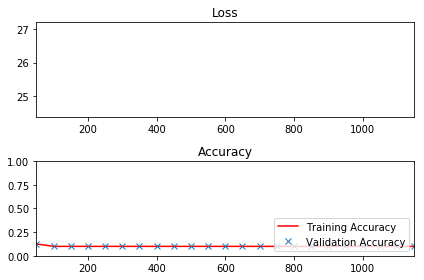

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.8 at 0.10013332962989807

EPOCHS=1, LEARNING_RATE=0.5:



Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 124.47batches/s]


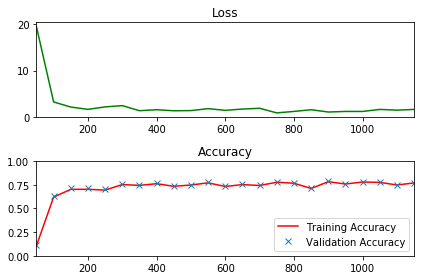

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.5 at 0.7749333381652832

EPOCHS=1, LEARNING_RATE=0.1:



Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 125.12batches/s]


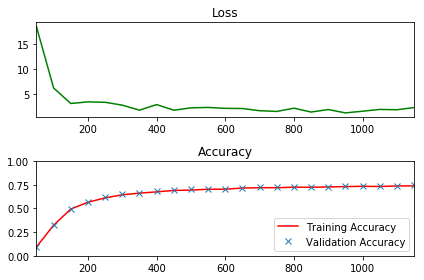

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.1 at 0.7337332963943481

EPOCHS=1, LEARNING_RATE=0.05:



Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 125.95batches/s]


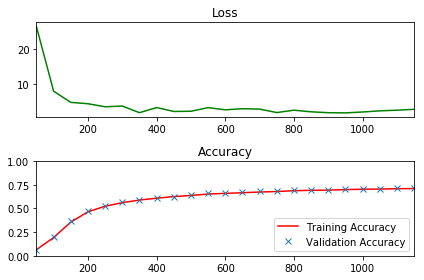

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.05 at 0.7158666849136353

EPOCHS=1, LEARNING_RATE=0.01:



Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 125.35batches/s]


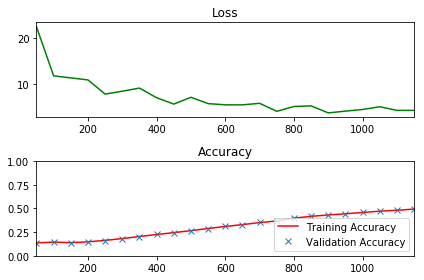

Epoch  1/1:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.01 at 0.49506670236587524

EPOCHS=1, LEARNING_RATE=0.2:



Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 124.58batches/s]


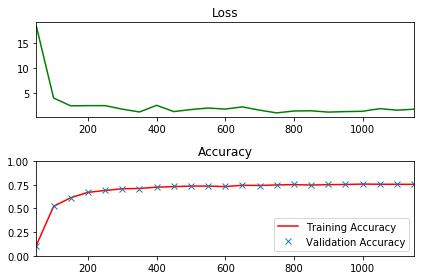

Epoch  1/2:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=1 and learning_rate=0.2 at 0.7550666332244873

EPOCHS=2, LEARNING_RATE=0.2:



Epoch  2/2: 100%|██████████| 1114/1114 [00:08<00:00, 125.57batches/s]


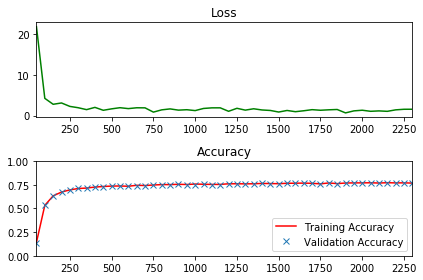

Epoch  1/3:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=2 and learning_rate=0.2 at 0.769066572189331

EPOCHS=3, LEARNING_RATE=0.2:



Epoch  3/3: 100%|██████████| 1114/1114 [00:08<00:00, 125.14batches/s]


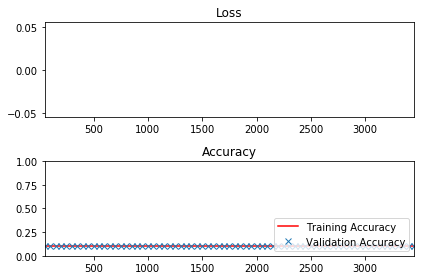

Epoch  1/4:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=3 and learning_rate=0.2 at 0.10013332962989807

EPOCHS=4, LEARNING_RATE=0.2:



Epoch  4/4: 100%|██████████| 1114/1114 [00:08<00:00, 125.59batches/s]


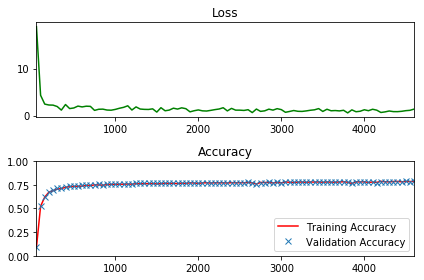

Epoch  1/5:   0%|          | 0/1114 [00:00<?, ?batches/s]

Validation accuracy with epochs=4 and learning_rate=0.2 at 0.7727999091148376

EPOCHS=5, LEARNING_RATE=0.2:



Epoch  5/5: 100%|██████████| 1114/1114 [00:08<00:00, 125.52batches/s]


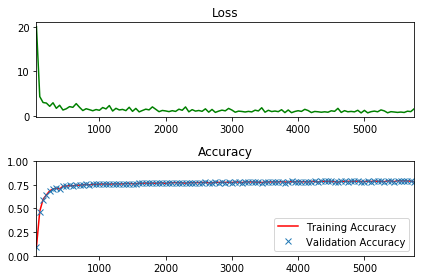

Validation accuracy with epochs=5 and learning_rate=0.2 at 0.7865332961082458


In [26]:
networkTrainer = NetworkTrainer()

# Find the best parameters for each configuration
for epochs in epochs_1:
    for learning_rate in learning_rate_1:
        print('\nEPOCHS={}, LEARNING_RATE={}:\n'.format(epochs, learning_rate))
        networkTrainer.train_neural_network(epochs, learning_rate)

for epochs in epochs_2:
    for learning_rate in learning_rate_2:
        print('\nEPOCHS={}, LEARNING_RATE={}:\n'.format(epochs, learning_rate))
        networkTrainer.train_neural_network(epochs, learning_rate)     

In [27]:
epochs = 1
learning_rate = 0.1

Epoch  1/1: 100%|██████████| 1114/1114 [00:08<00:00, 125.25batches/s]


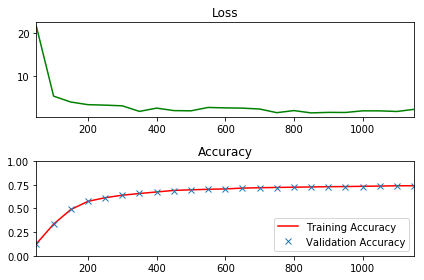

Validation accuracy with epochs=1 and learning_rate=0.1 at 0.73826664686203


In [28]:
networkTrainer.train_neural_network(epochs, learning_rate)

## NetworkTester

In [29]:
class NetworkTester:
    
    def test_neural_network(self):
        networkBuilder = NetworkBuilder()
        optimizer = networkBuilder.get_optimizer(learning_rate, loss)
        
        test_accuracy = 0.0
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            batch_count = int(math.ceil(len(train_features)/batch_size))
            
            for e in range(epochs):
                batches_pbar = tqdm(range(batch_count), 
                                    desc='Epoch {:>2}/{}'.format(e+1, epochs), 
                                    unit='batches')
                
                for batch_idx in batches_pbar:
                    batch_start = batch_idx*batch_size
                    batch_features = train_features[batch_start:batch_start + batch_size]
                    batch_labels = train_labels[batch_start:batch_start + batch_size]

                    # Run optimizer
                    _ = sess.run(optimizer, feed_dict={features: batch_features, 
                                                          labels: batch_labels})
                    
                # Check accuracy against test data
                test_accuracy = sess.run(accuracy, feed_dict=test_feed_dict)
                
        return test_accuracy

In [30]:
networkTester = NetworkTester()

test_accuracy = networkTester.test_neural_network()

assert test_accuracy >= 0.80, \
    'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)

print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  1/1: 100%|██████████| 1114/1114 [00:01<00:00, 613.58batches/s]

Nice Job! Test Accuracy is 0.8082999587059021
